In [1]:
from __future__ import absolute_import, division, print_function
#..
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import pyart.graph.cm as pcm
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import os,subprocess,time,copy
import random
import scipy
import math
import matplotlib.gridspec as gridspec
#import cPickle as pickle
import pickle
import pymc as pm
import arviz as az
import emulator_fun as ef

#import pymc3
#import pyGPs
#..
import pathlib
import pandas as pd
#import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pytensor
import pytensor.tensor as pt
print(tf.__version__)
print(pm.__version__)
import re
import csv
from io import StringIO
#..
import corner
#..
#import pymc
#import pandas as pd
#print('Running on PyMC3 v{}'.format(pm.__version__))
#import theano
#import theano.tensor as t
%matplotlib inline

# allocating GPU memory

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # in MB
        )
    except RuntimeError as e:
        print(e)

2025-03-04 21:40:08.570254: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 21:40:08.584239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741142408.597103 2171601 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741142408.600916 2171601 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 21:40:08.616588: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2.18.0
5.20.1


# K1D BOSS single-cat PPE->CPE started Oct 22nd 2024

## Preprocess data

In [2]:
#..First load that data to see what it looks like
base_path = '/home/arthurhu/BOSS_PPE/PPE csv/'
ppe_params_fn = 'condcoll_ppe_isd_def0.2_ppe_params.csv'
ppe_params_valid_fn = 'condcoll_ppe_isd_def0.2_valid_ppe_params.csv'
ppe_sim_fn = 'condcoll_ppe_isd_def0.2_ppe_var.csv'
ppe_sim_valid_fn = 'condcoll_ppe_isd_def0.2_valid_ppe_var.csv'
target_var_fn = 'condcoll_target_var.csv'

In [3]:
param_all_idx = np.arange(35)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
param_interest_idx = np.concatenate((np.arange(0,4), np.arange(12,24)))
param_not_int_idx = [i for i in param_all_idx if i not in param_interest_idx]

param_train = ef.get_params(base_path, ppe_params_fn, param_interest_idx)
param_valid = ef.get_params(base_path, ppe_params_valid_fn, param_interest_idx)
ppe_sim_train = ef.get_vars(base_path, ppe_sim_fn)
ppe_sim_valid = ef.get_vars(base_path, ppe_sim_valid_fn)
tgt_sim = ef.get_vars(base_path, target_var_fn)

nobs = ppe_sim_train['vals'].shape[1]

/home/arthurhu/BOSS_PPE/emulator_fun.py:19: RuntimeWarning: divide by zero encountered in log
  var_vals_log = np.log(var_vals)
/home/arthurhu/BOSS_PPE/emulator_fun.py:19: RuntimeWarning: divide by zero encountered in log
  var_vals_log = np.log(var_vals)
/home/arthurhu/BOSS_PPE/emulator_fun.py:19: RuntimeWarning: divide by zero encountered in log
  var_vals_log = np.log(var_vals)


In [4]:
ppe_sim_train['log_vals']

masked_array(
  data=[[-3.300093464455291, 28.438278697487597, -3.6748346841120783,
         ..., 28.566306178000637, 28.566305872618248, 28.566305579685995],
        [-6.371089847157456, 21.817259387921762, --, ...,
         14.347990380947918, 14.348071706422948, 14.348153203576869],
        [-4.631169904597186, 27.50204903064584, -5.2044932912494035, ...,
         27.624048128442602, 27.624048132316386, 27.624048132034297],
        ...,
        [-8.766606902894686, 26.193140794314488, -21.571155346482012,
         ..., 26.31556268650179, 26.315562556129027, 26.315562475524317],
        [-5.672136741834349, 19.78489358227595, --, ...,
         15.016689441618247, 15.016747476025131, 15.016805467472423],
        [-4.9177793383662065, 22.963704057315304, -20.742732653493857,
         ..., 21.379793418715938, 21.3711740856998, 21.36524483924414]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        [False, False, Fals

In [5]:
tgt_sim['log_vals'][0,2:].shape

(62,)

/home/arthurhu/BOSS_PPE/.venv/lib/python3.10/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


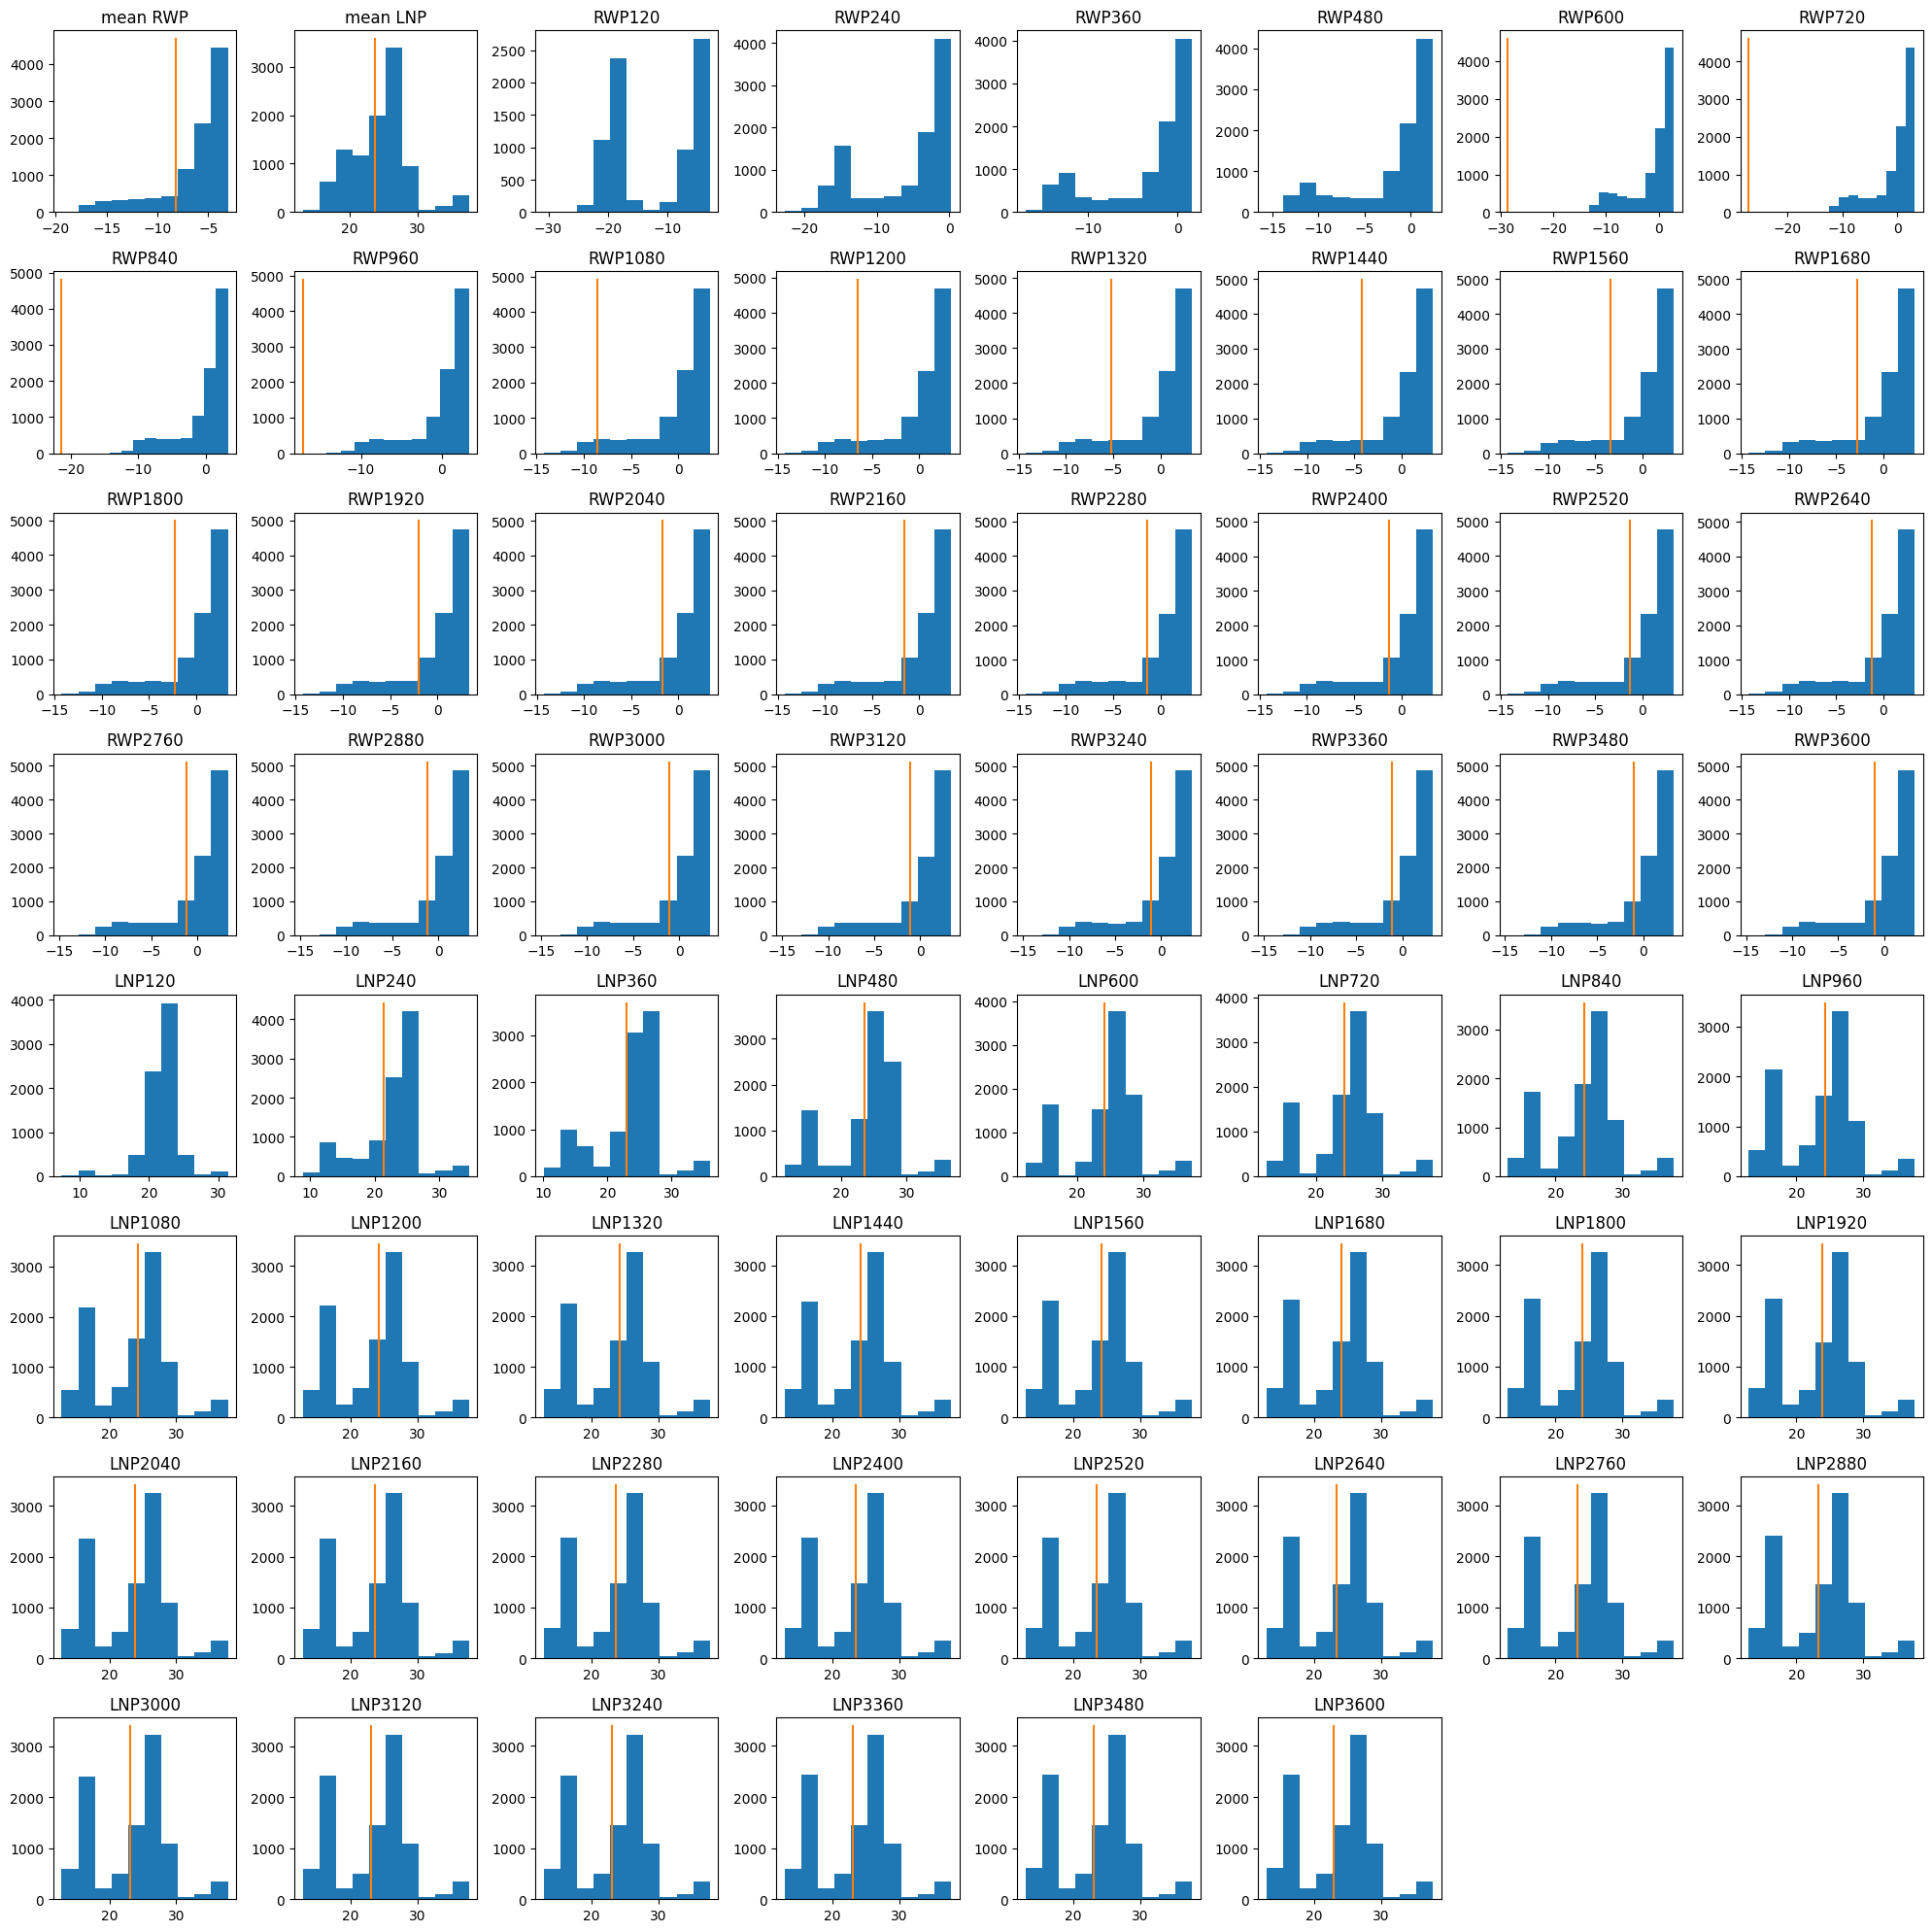

In [6]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(8,8)
ii=1
for i in range(nobs):
    ax = fig.add_subplot(gs[i])
    hst = ax.hist(ppe_sim_train['log_vals'][:, i])
    plt.plot((tgt_sim['log_vals'][0, i + 2], tgt_sim['log_vals'][0, i + 2]), ax.get_ylim())
    plt.title(ppe_sim_train['var_names'][i])
    # plt.xscale('log')

fig.tight_layout()

In [7]:
import sklearn.model_selection as mod_sec
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing

In [8]:
preprocessing.StandardScaler().fit(ppe_sim_train['log_vals'])

StandardScaler()

In [9]:
#..normalize the parameters (range 0 to 1) and standardize the obs (standard deviation=1, mean=0)
minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
param_norm = minmaxscale.transform(param_train['vals'])
param_norm_valid = minmaxscale.transform(param_valid['vals'])

#param_norm = param_norm.feature_range
#..
standscale = preprocessing.StandardScaler().fit(ppe_sim_train['log_vals'])
ppe_sim_stand = np.ma.masked_invalid(standscale.transform(ppe_sim_train['log_vals']))
ppe_sim_stand_valid = np.ma.masked_invalid(standscale.transform(ppe_sim_valid['log_vals']))

In [10]:
print(param_norm.shape)
print(ppe_sim_stand.shape)
npar = param_norm.shape[1]
nobs = ppe_sim_stand.shape[1]
print(npar,nobs)

(10000, 18)
(10000, 62)
18 62


In [11]:
#..split into training and validation (let's forget about test right now)
param_norm, param_norm_valid, ppe_sim_stand, ppe_sim_stand_valid = mod_sec.train_test_split(param_norm, ppe_sim_stand, test_size=0.2, random_state=1)
print(param_norm.shape, param_norm_valid.shape, ppe_sim_stand.shape, ppe_sim_stand_valid.shape)

(8000, 18) (2000, 18) (8000, 62) (2000, 62)


In [12]:
type(param_norm)

numpy.ndarray

## Start training NNs

In [13]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [14]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.plot(hist['epoch'],0.1+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.2+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.3+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.4+0.*hist['epoch'],'k:')
    #plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.plot(hist['epoch'],0.1+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.2+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.3+0.*hist['epoch'],'k:')
    plt.plot(hist['epoch'],0.4+0.*hist['epoch'],'k:')
    #plt.ylim([0,1])
    plt.legend()
    plt.show()

In [15]:
print(npar)

18


In [16]:
#..Build da model ... standard setup
def build_model_00():
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(64, activation=tf.nn.relu),
                              layers.Dense(64, activation=tf.nn.relu),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [17]:
print(param_norm.shape, ppe_sim_stand.shape)

(8000, 18) (8000, 62)


I0000 00:00:1741142426.652422 2171601 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:e1:00.0, compute capability: 8.0
I0000 00:00:1741142427.757713 2172927 service.cc:148] XLA service 0x7f4308005e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741142427.757751 2172927 service.cc:156]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-03-04 21:40:27.772041: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741142427.815749 2172927 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1741142429.133726 2172927 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

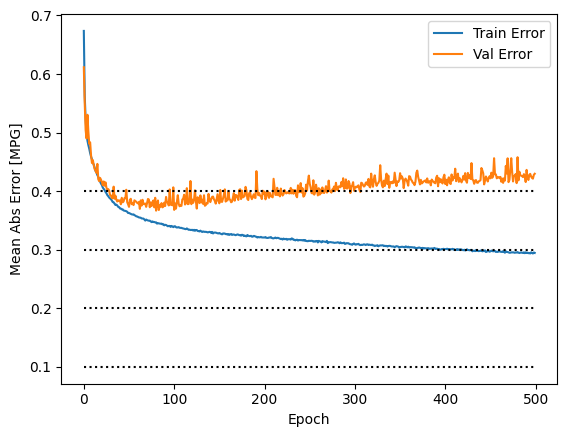

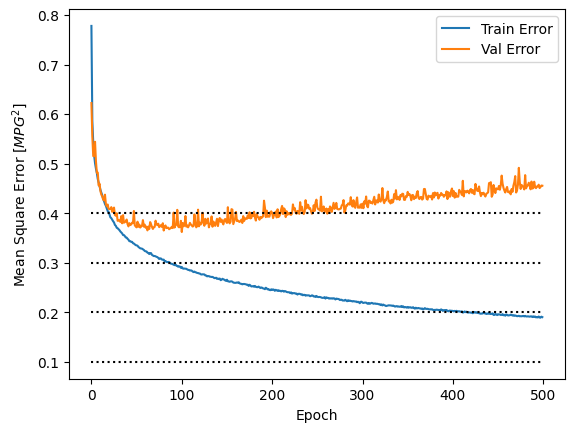

In [18]:
model_00 = build_model_00()
EPOCHS = 500        
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_00.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])
plot_history(history)

In [19]:
#..Build da model ... deep neural network 01  (looks about the same)
def build_model_01():
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(64, activation=tf.nn.relu),
                              layers.Dense(256, kernel_initializer='normal',activation='relu'),
                              layers.Dense(256, kernel_initializer='normal',activation='relu'),
                              layers.Dense(256, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=.00005)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  #optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

2025-03-04 21:47:09.317747: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_381', 4 bytes spill stores, 4 bytes spill loads

2025-03-04 21:47:09.956836: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_383', 68 bytes spill stores, 72 bytes spill loads

2025-03-04 21:47:09.957924: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_383', 24 bytes spill stores, 24 bytes spill loads

2025-03-04 21:47:09.962938: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_383', 60 bytes spill stores, 64 bytes spill loads

2025-03-04 21:47:10.000020: I external/local_xla/xla/stream_execut


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

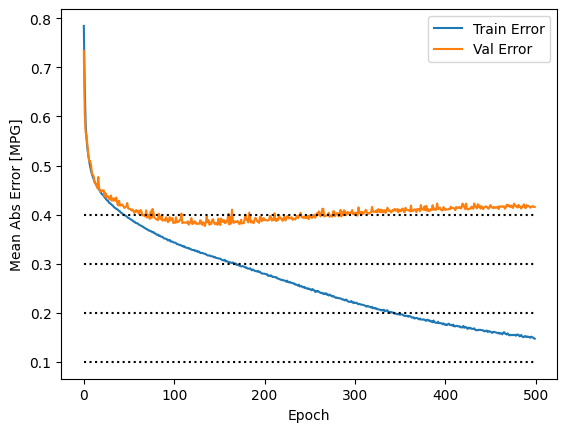

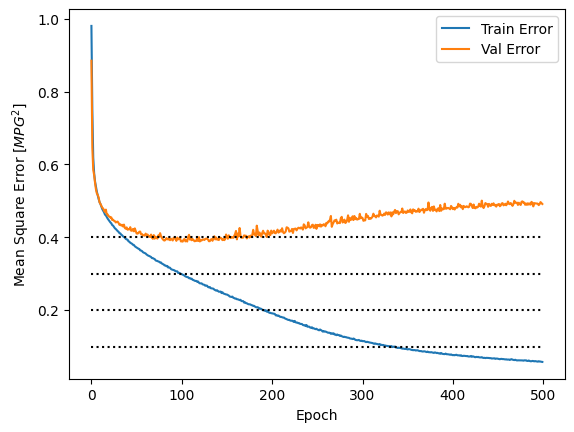

In [20]:
model_01 = build_model_01()
EPOCHS = 500        
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_01.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])
plot_history(history)

In [21]:
#..Build da model ... deep neural network 02  (looks a bit better)
def build_model_02():
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(64, activation=tf.nn.relu),
                              layers.Dense(64, kernel_initializer='normal',activation='relu'),
                              layers.Dense(64, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=.0001)


    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  #optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [22]:
model_02 = build_model_02()
EPOCHS = 500        
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_02.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])


...

.................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

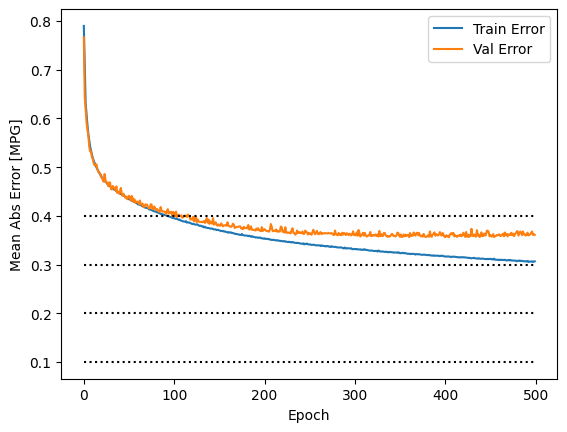

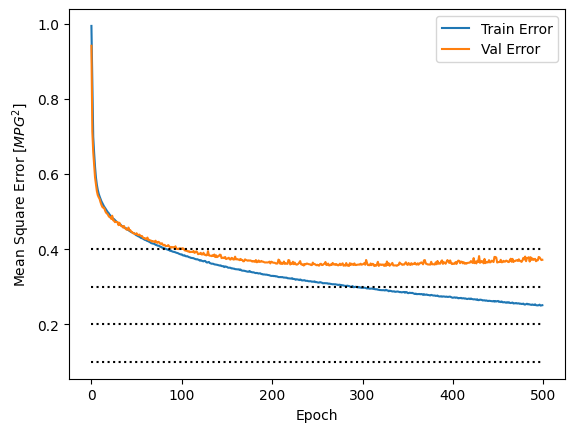

In [23]:
plot_history(history)

In [24]:
#..Build da model ... deep neural network 03 (not any better than 1)
def build_model_03():
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(64, activation=tf.nn.relu),
                              layers.Dense(64, kernel_initializer='normal',activation='relu'),
                              layers.Dense(64, kernel_initializer='normal',activation='relu'),
                              layers.Dense(64, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=.0001)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  #optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


...........

.........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

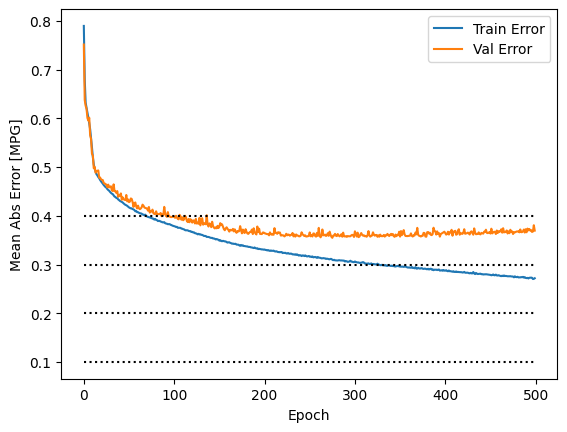

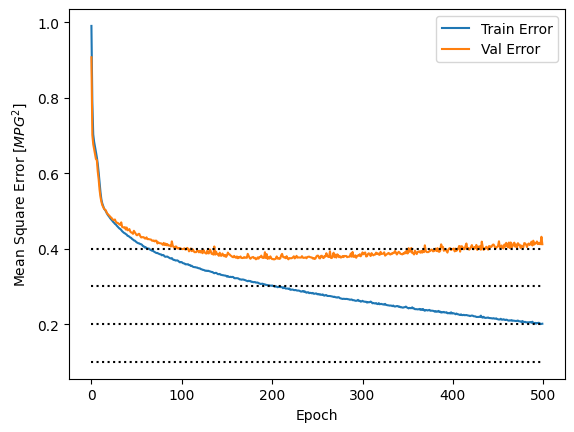

In [25]:
model_03 = build_model_03()
EPOCHS = 500        
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_03.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])
plot_history(history)

In [26]:
#..Build da model ... deep neural network 04  
def build_model_04():
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(64, activation=tf.nn.relu),
                              layers.Dense(128, kernel_initializer='normal',activation='relu'),
                              layers.Dense(128, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  #optimizer=optimizer,
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

2025-03-04 22:08:01.023435: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_328', 4 bytes spill stores, 4 bytes spill loads

2025-03-04 22:08:01.100540: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_330', 60 bytes spill stores, 64 bytes spill loads




............

........................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

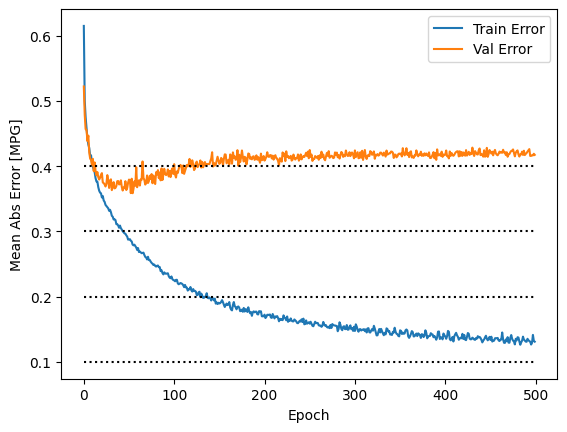

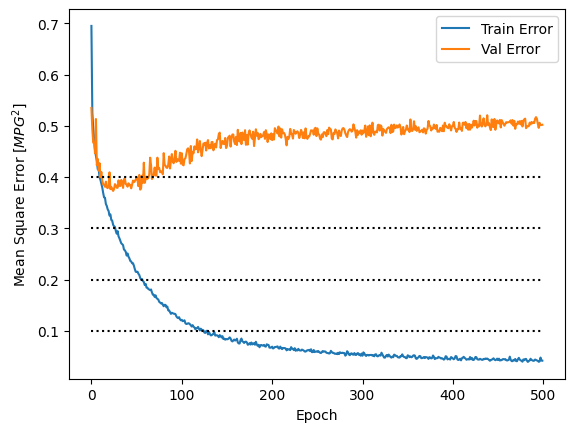

In [27]:
model_04 = build_model_04()
EPOCHS = 500        
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_04.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])
plot_history(history)

In [28]:
#..Build da model ... deep neural network 05  
def build_model_05():
    def lrelu_01(x): return tf.nn.leaky_relu(x, alpha=0.01)
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(64, activation=lrelu_01),
                              layers.Dense(64, kernel_initializer='normal',activation=lrelu_01),
                              layers.Dense(64, kernel_initializer='normal',activation=lrelu_01),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  #optimizer=optimizer,
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


..................

..................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

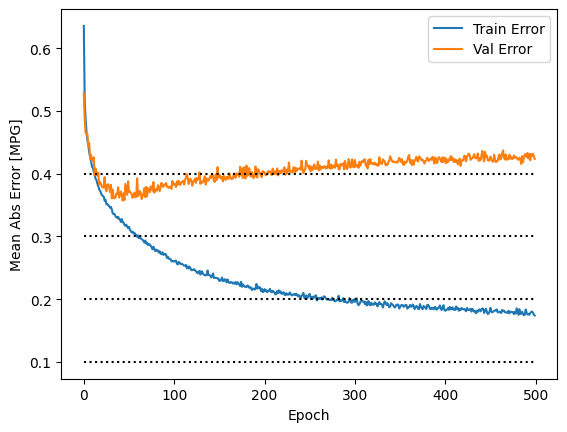

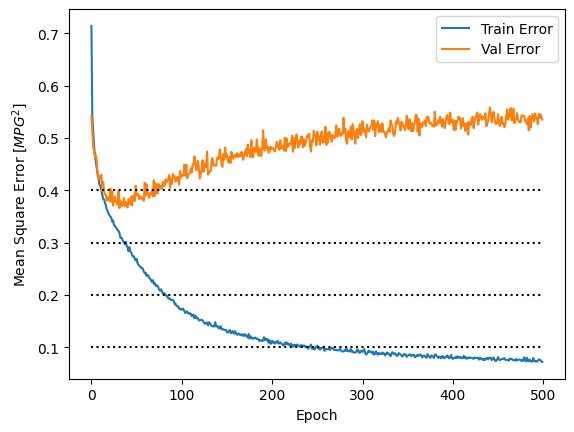

In [29]:
model_05 = build_model_05()
EPOCHS = 500        
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_05.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])
plot_history(history)

In [30]:
#..Build da model ... deep neural network 06 
def build_model_06():
    def lrelu_01(x): return tf.nn.leaky_relu(x, alpha=0.01)
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(64, activation=lrelu_01),
                              layers.Dense(64, kernel_initializer='normal',activation=lrelu_01),
                              layers.Dense(64, kernel_initializer='normal',activation=lrelu_01),
                              layers.Dense(64, kernel_initializer='normal',activation=lrelu_01),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  #optimizer=optimizer,
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


...................

.................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

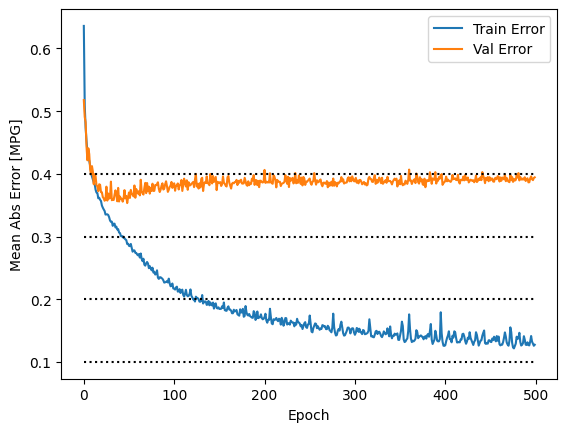

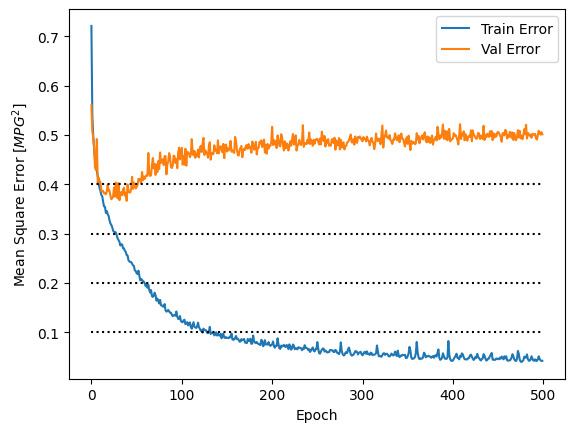

In [31]:
model_06 = build_model_06()
EPOCHS = 500        
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_06.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])
plot_history(history)

In [32]:
#..Build da model ... deep neural network 07
def build_model_07():
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(40, activation=tf.nn.relu),
                              layers.Dense(40, kernel_initializer='normal',activation='relu'),
                              layers.Dense(40, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  #optimizer=optimizer,
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


......................

..............................................................................
....................................................................................................

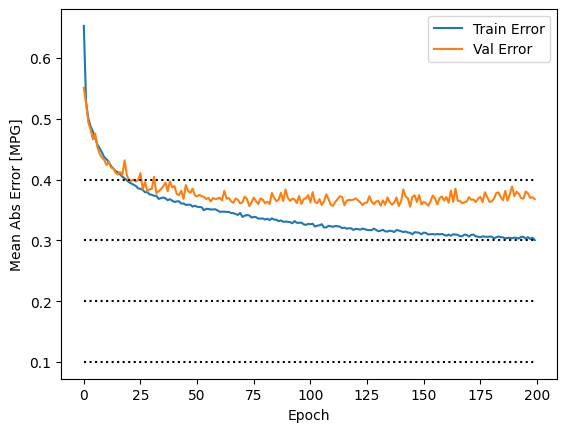

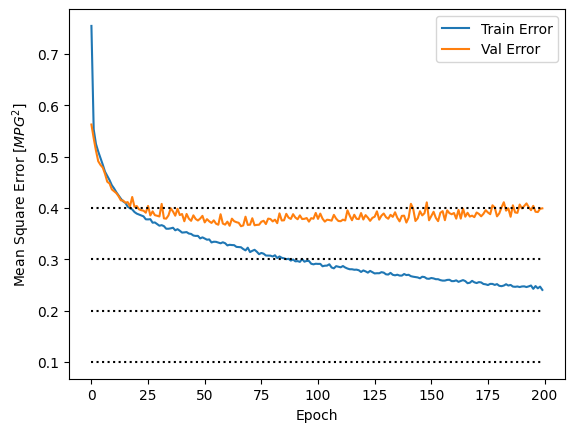

In [33]:
model_07 = build_model_07()
EPOCHS = 200       
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_07.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])
plot_history(history)

In [34]:
#..Build da model ... deep neural network 08
def build_model_08():
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(40, activation=tf.nn.relu),
                              layers.Dense(40, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  #optimizer=optimizer,
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


...................................

.................................................................
....................................................................................................

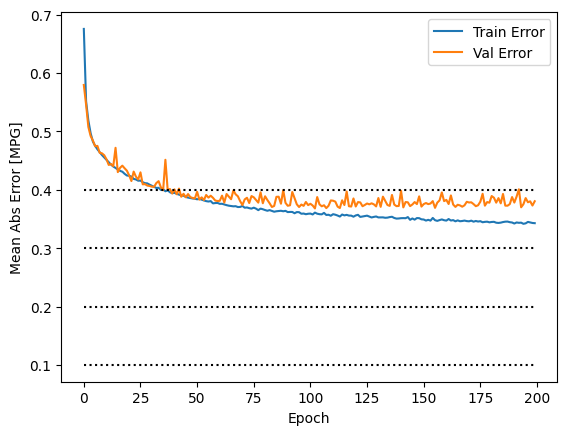

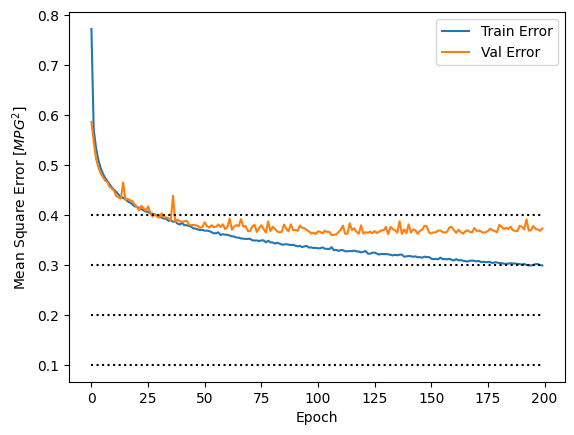

In [35]:
model_08 = build_model_08()
EPOCHS = 200       
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_08.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])
plot_history(history)

In [36]:
#..Build da model ... deep neural network 09
def build_model_09():
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(40, activation=tf.nn.relu),
                              layers.Dense(40, kernel_initializer='normal',activation='relu'),
                              #layers.Dense(40, kernel_initializer='normal',activation='relu'),
                              layers.Dense(40, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  #optimizer=optimizer,
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


.................................................

...................................................
....................................................................................................

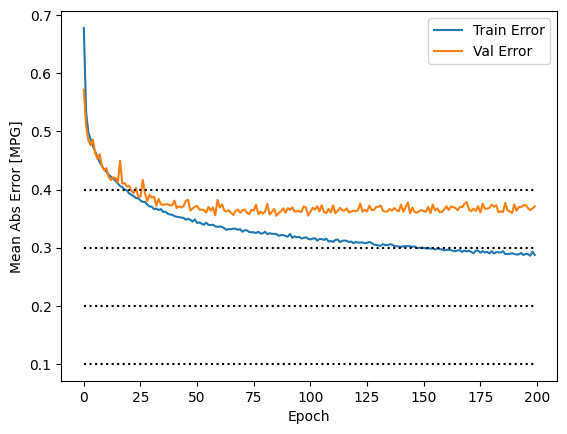

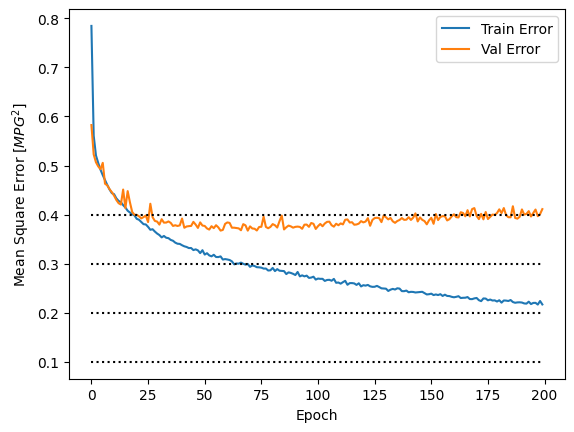

In [37]:
model_09 = build_model_09()
EPOCHS = 200       
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_09.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])
plot_history(history)

In [38]:
#..Build da model ... deep neural network 09
def build_model_10():
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(64, activation=tf.nn.relu),
                              layers.Dense(128, kernel_initializer='normal',activation='relu'),
                              #layers.Dense(40, kernel_initializer='normal',activation='relu'),
                              layers.Dense(256, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  #optimizer=optimizer,
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

2025-03-04 22:37:19.786583: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_330', 68 bytes spill stores, 72 bytes spill loads

2025-03-04 22:37:19.790368: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_330', 60 bytes spill stores, 64 bytes spill loads




.............................................................

.......................................
....................................................................................................

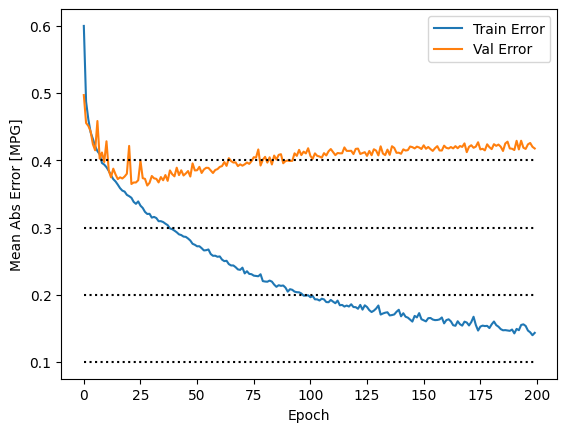

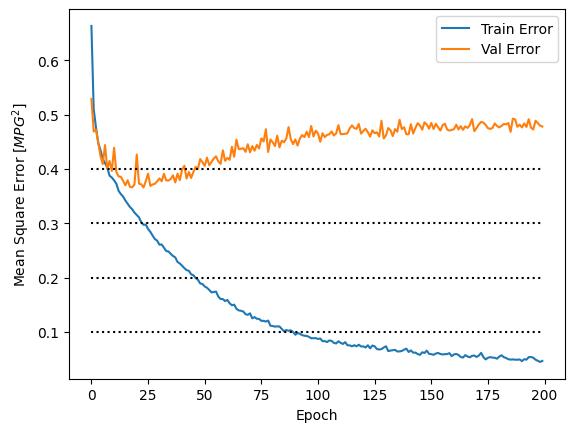

In [39]:
model_10 = build_model_10()
EPOCHS = 200       
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_10.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])
plot_history(history)

In [40]:
#..Build da model ... deep neural network 09
def build_model_11():
    model = keras.Sequential([layers.Input(shape=(npar,)),
                              layers.Dense(64, activation=tf.nn.relu),
                              layers.Dense(128, kernel_initializer='normal',activation='relu'),
                              #layers.Dense(40, kernel_initializer='normal',activation='relu'),
                              layers.Dense(256, kernel_initializer='normal',activation='relu'),
                              layers.Dense(512, kernel_initializer='normal',activation='relu'),
                              layers.Dense(nobs) ])
#                              layers.Dense(1) ])

    #optimizer = tf.keras.optimizers.RMSprop(0.001)

    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    #model.summary()
    
    model.compile(loss='mean_squared_error',
                  #optimizer=optimizer,
                  optimizer='adam',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

2025-03-04 22:40:10.358135: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_257', 48 bytes spill stores, 48 bytes spill loads

2025-03-04 22:40:10.362792: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_385', 68 bytes spill stores, 72 bytes spill loads

2025-03-04 22:40:10.363368: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_385', 24 bytes spill stores, 24 bytes spill loads

2025-03-04 22:40:10.370440: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_385', 60 bytes spill stores, 64 bytes spill loads

2025-03-04 22:40:10.388601: I external/local_xla/xla/stream_exec


....................................................................................................
....................................................................................................

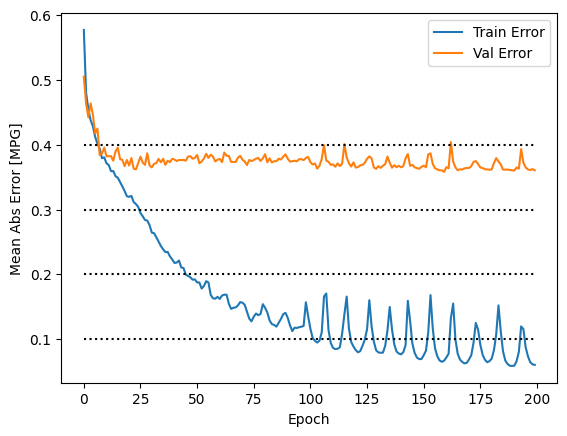

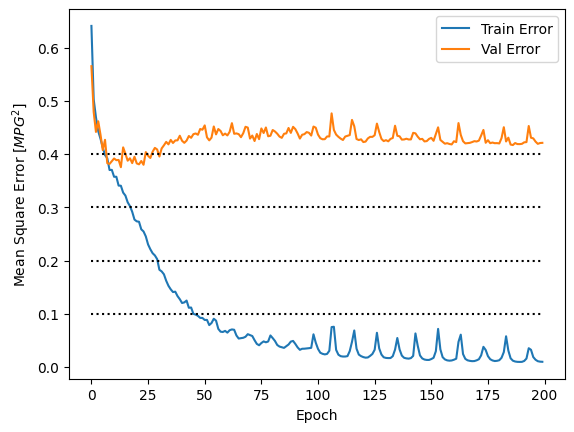

In [41]:
model_11 = build_model_11()
EPOCHS = 200       
#EPOCHS = 5000

#history = model.fit(params_norm.T, obs_stan[0,:], epochs=EPOCHS, validation_split = 0.232558, verbose=0,
#history = model.fit(params_norm.T, obs_stan.T, epochs=EPOCHS, validation_split = 0.2, verbose=0,
history = model_11.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                    validation_data = [param_norm_valid,ppe_sim_stand_valid], 
                    verbose=0,
                    callbacks=[PrintDot()])
plot_history(history)

In [42]:
# gs = gridspec.GridSpec(nobs,npar)
# fig = plt.figure(figsize=(40,30))
# for i in range(nobs):
#     for j in range(npar):
#         ax = fig.add_subplot(gs[i,j])
#         ax.scatter(param_vals[:,j],ppe_sim_train['vals'][:,i],alpha=.1)
#         #ax.scatter(param_norm_valid[:,j],ppe_sim_stand_valid[:,i],alpha=.1)
        

In [43]:
# gs = gridspec.GridSpec(npar,nobs)
# fig = plt.figure(figsize=(30,40))
# for i in range(npar):
#     for j in range(nobs):
#         ax = fig.add_subplot(gs[i,j])
#         ax.scatter(ppe_sim_train['vals'][:,j],param_vals[:,i],alpha=.1)
#         #ax.scatter(param_norm_valid[:,j],ppe_sim_stand_valid[:,i],alpha=.1)

## Put everything together and prep for MCMC

In [44]:
model_01 = build_model_01()
model_02 = build_model_02()
model_03 = build_model_03()
model_04 = build_model_04()
model_05 = build_model_05()
model_06 = build_model_06()
model_07 = build_model_07()
model_08 = build_model_08()
model_09 = build_model_09()
model_10 = build_model_10()


.............

..........................................................................

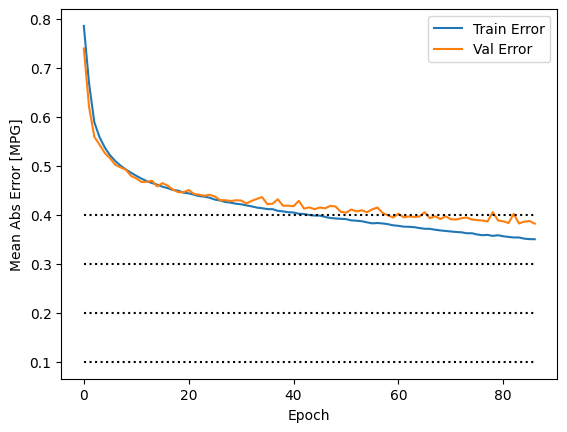

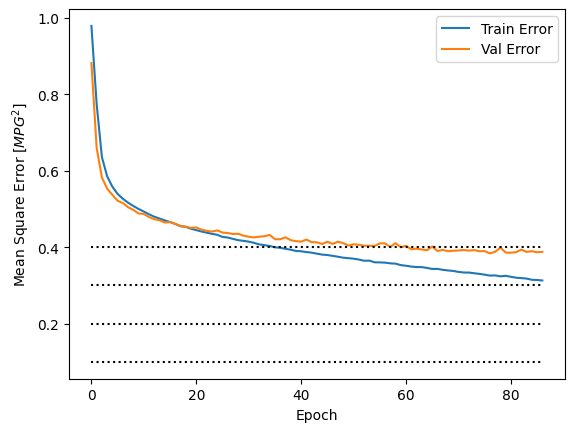


....................................................................................................
................................................................................................

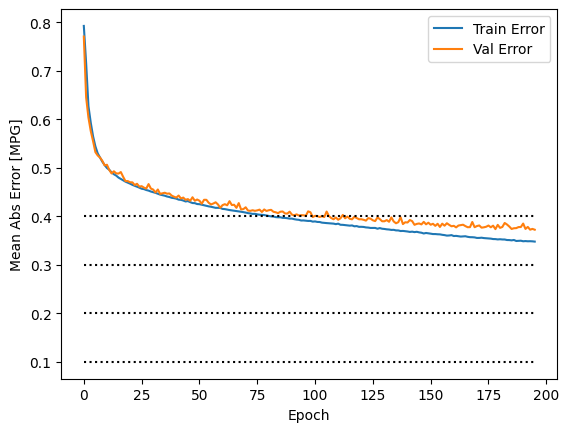

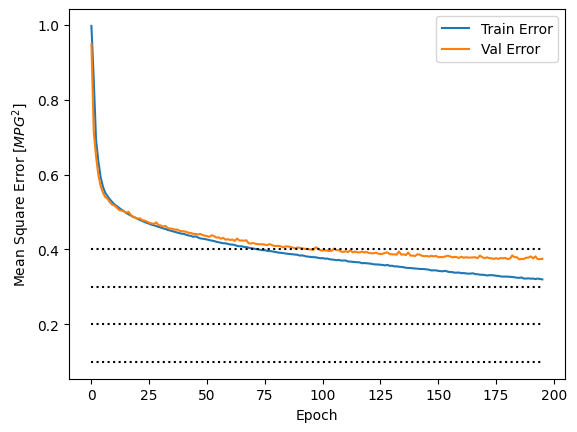


....................................................................................................
.....................................................................................

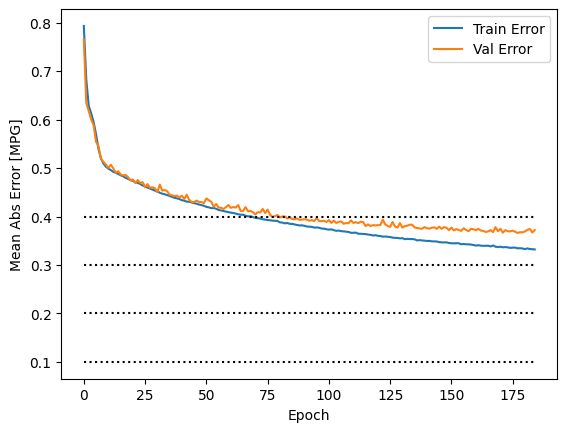

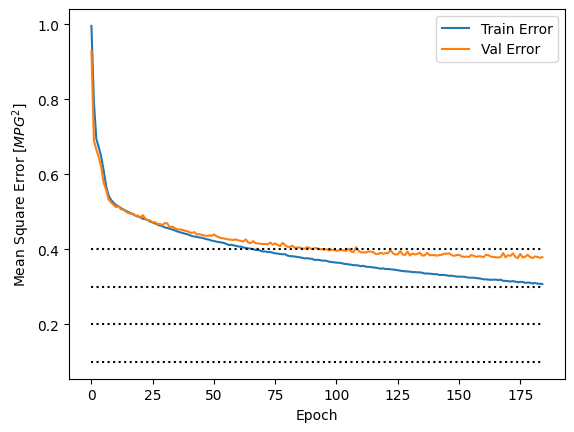


.................................

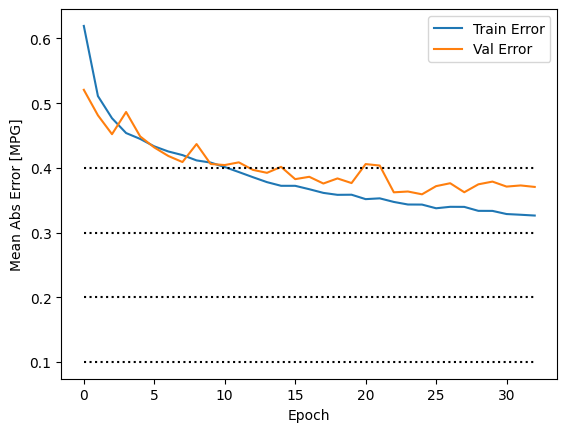

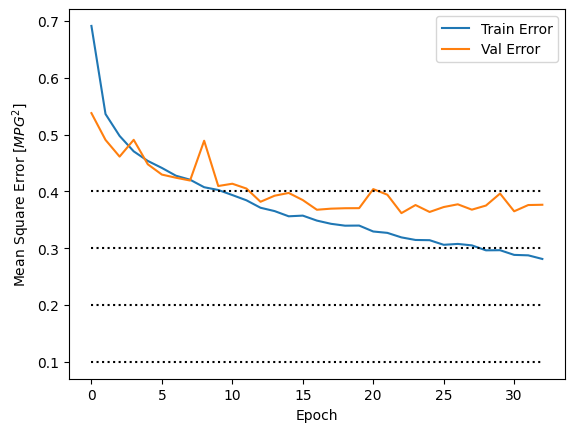


.......................................

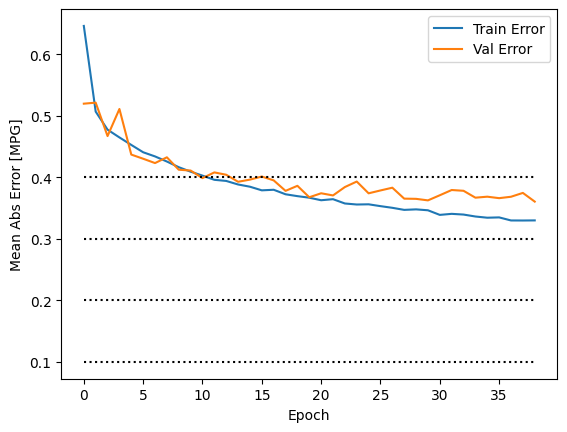

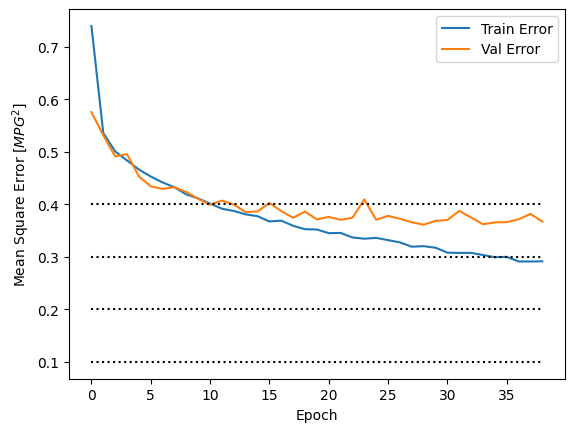


...........................

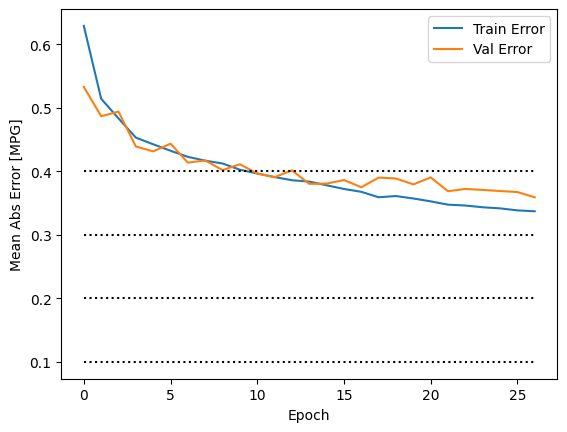

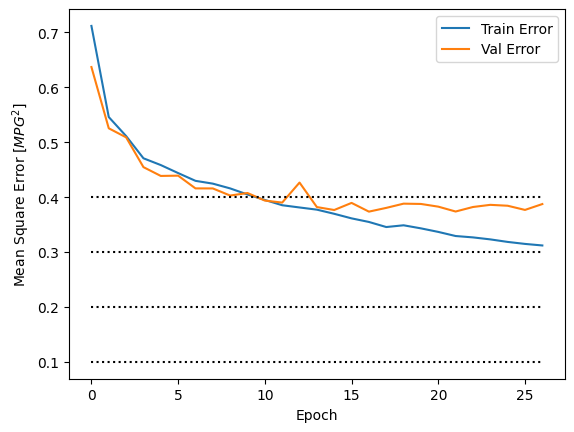


.............................................................

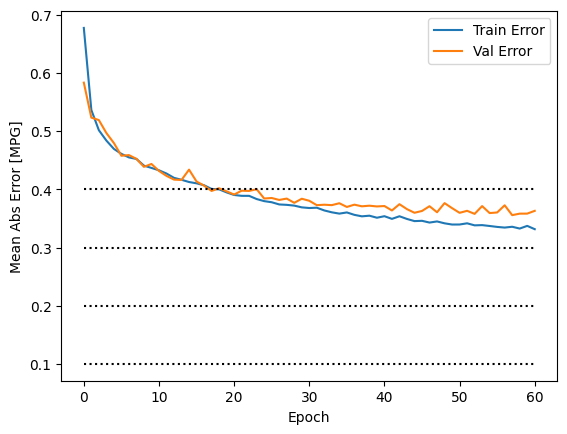

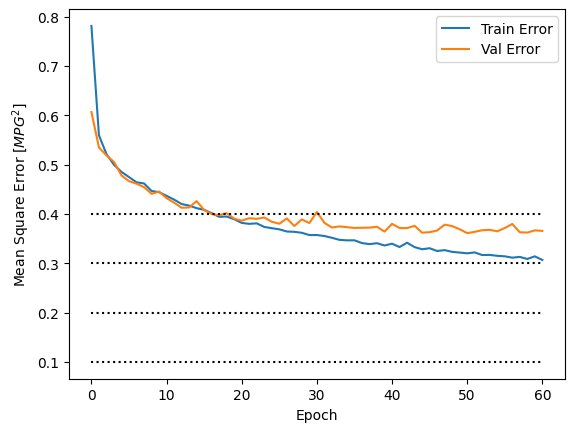


...............................................................................................

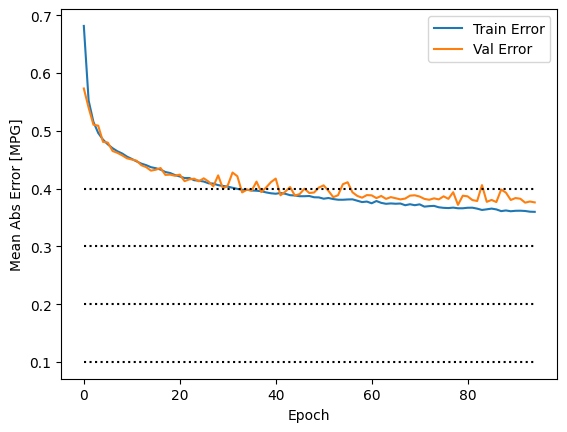

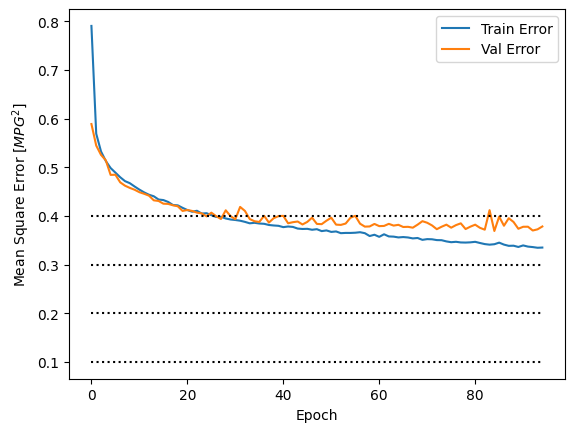


.......................................................

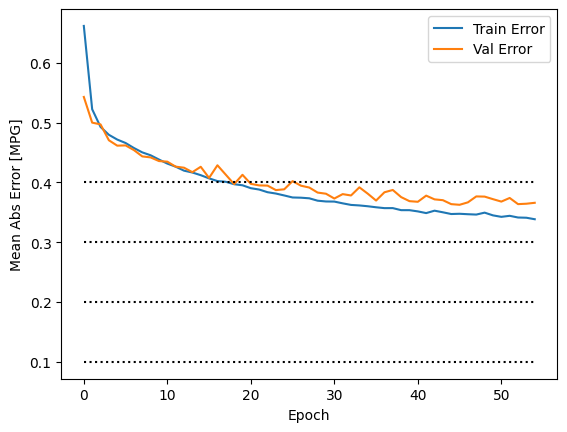

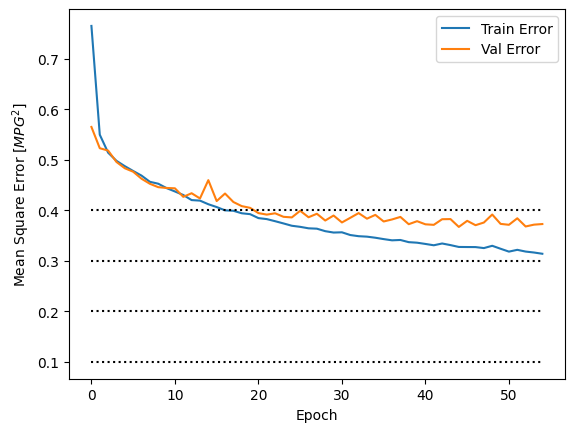


....................................

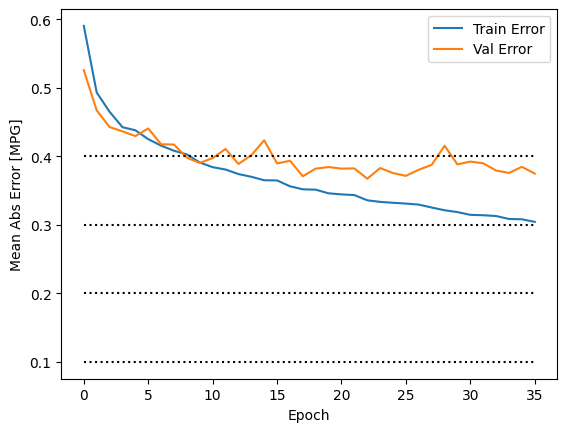

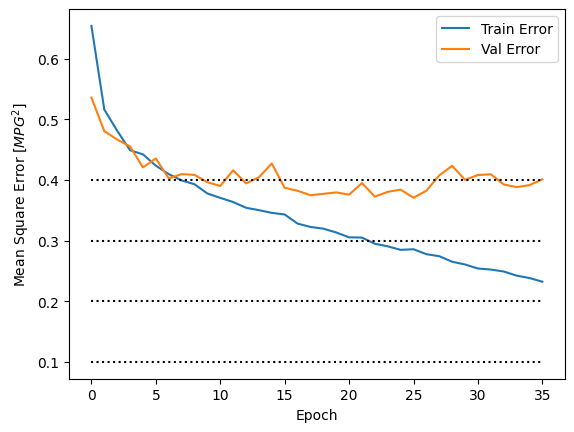

In [45]:
EPOCHS = 1000
modelss = [model_01,model_02,model_03,model_04,model_05,
           model_06,model_07,model_08,model_09,model_10]


# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

for modell in modelss:
    history = modell.fit(param_norm, ppe_sim_stand, epochs=EPOCHS, 
                         validation_data = [param_norm_valid, ppe_sim_stand_valid], 
                         verbose=0,
                         callbacks=[early_stop, PrintDot()])
    plot_history(history) 

### average ensemble model

In [46]:
# import Average layer
from tensorflow.keras.layers import Average 

input = tf.keras.Input(shape=[npar], name='input')  # input layer

# get output for each input model
outputs = [model(input) for model in modelss] 

# take average of the outputs
output = Average()(outputs)

# create average ensembled model
avg_model = tf.keras.Model(input, output)

avg_model.save('condcoll_isd.keras')

In [47]:
print(Average()(outputs))
print(npar)

<KerasTensor shape=(None, 62), dtype=float32, sparse=False, name=keras_tensor_125>
18


In [48]:
def lrelu_01(x): return tf.nn.leaky_relu(x, alpha=0.01)
avg_model = tf.keras.models.load_model('condcoll_sd.keras', custom_objects={"lrelu_01": lrelu_01})
test_predictions_av = avg_model(param_norm_valid)

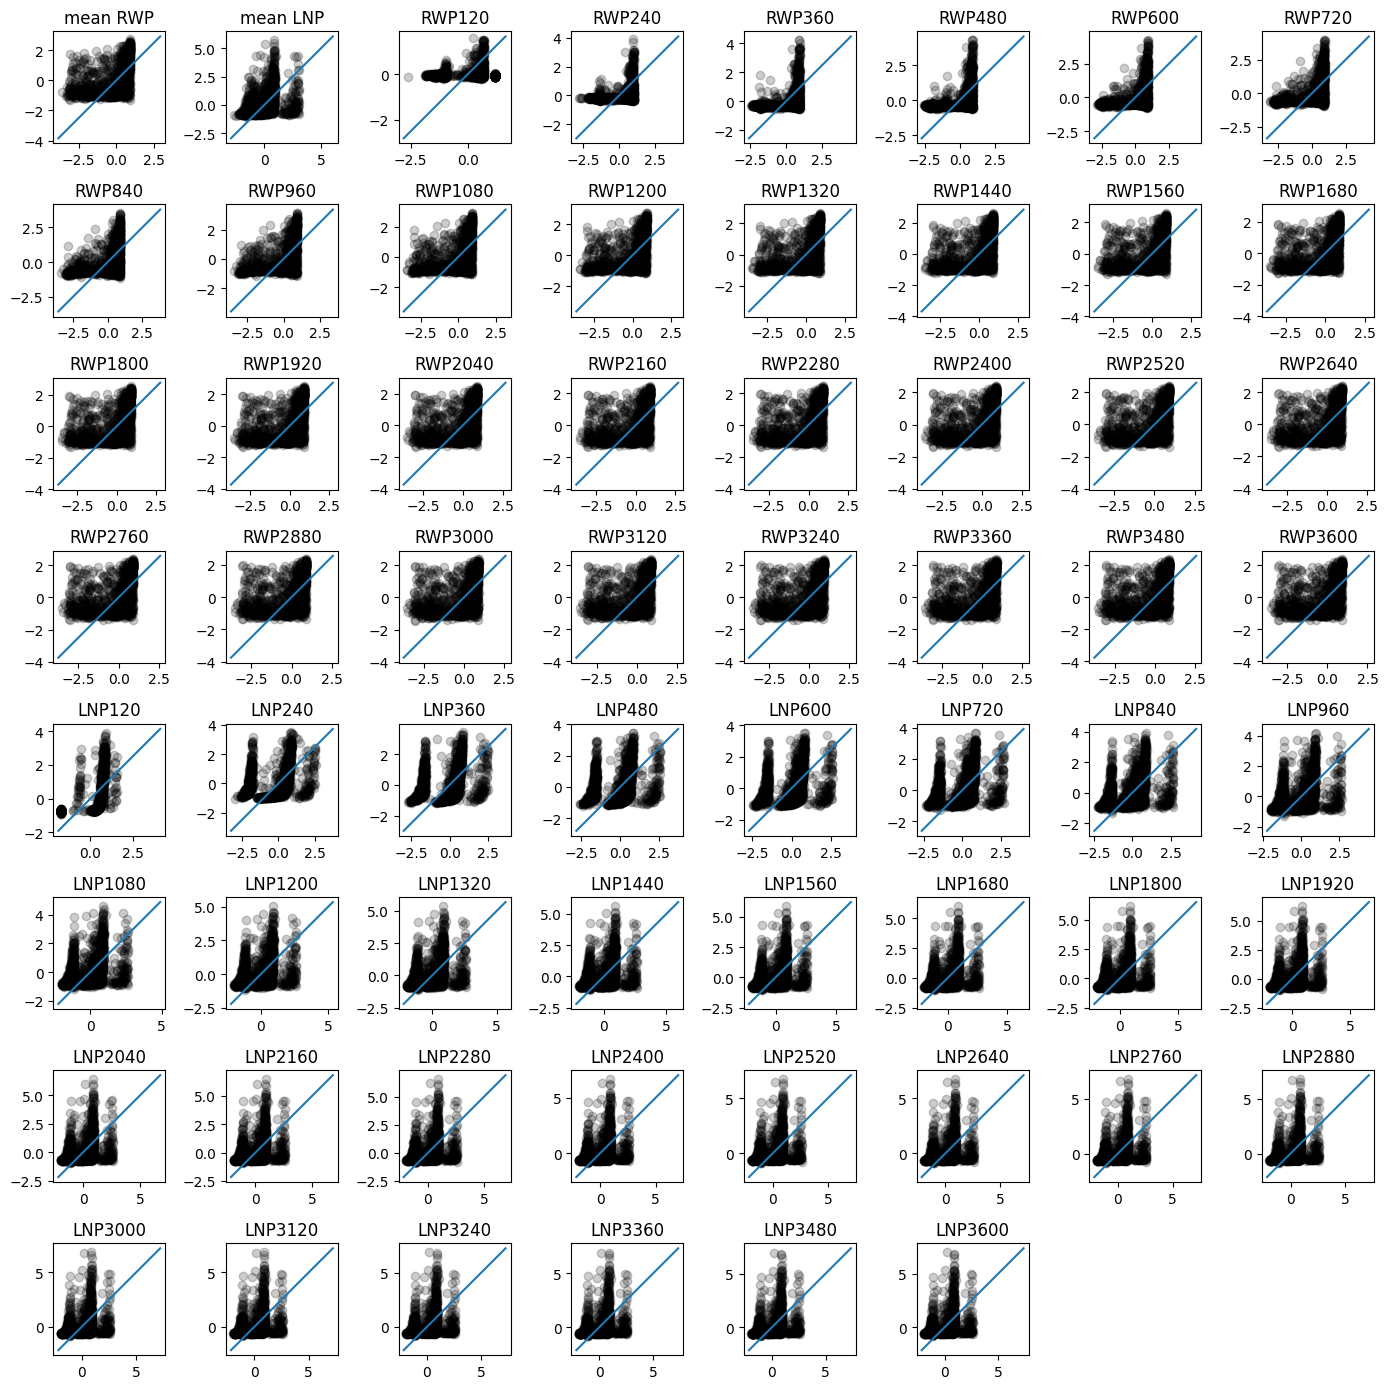

In [49]:
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(8,8)
ii=1
for i in range(nobs):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')
    plt.scatter(ppe_sim_stand_valid[:,i], test_predictions_av[:,i],alpha=0.2,c='k')
    plt.title(ppe_sim_train['var_names'][i])
    ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    plt.plot([ax_min, ax_max], [ax_min, ax_max])
fig.tight_layout()